In [15]:
### compute & plot taux, tauy, taux_correct, tauy_correct, raw & NI-bandpassed velocity, AND wind power input & integral of wind power input
### buoy current's grid: hourly
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import math
import sys
import re
from numpy.linalg import norm
from scipy.interpolate import interp1d
from metpy.calc import wind_components, density, mixing_ratio_from_relative_humidity, wind_direction
from metpy.units import units
from oceans.ocfis import spdir2uv
# from metpy import calc
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from windstr import ra_windstr_nc
from convert_dir import vector_dir_to_from
from mystats import bandpass

In [16]:
### Data info
### buoy data info
year = '2023'
buoy_id = '42022'
path_met_buoy = '/Users/chi/Documents/Data/NDBC/'
fn_met = 'met_ndbc'+buoy_id+'_y'+year+'.txt'
path_cur_buoy = '/Users/chi/Documents/Data/NDBC/'
fn_cur = 'current_ndbc'+buoy_id+'_y'+year+'.txt'
lat_buoy = 27.505
### SD data info
platf_num = '1042'
path_met_SD = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_airsea/'
path_cur_SD = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_adcp/'
### SD-1042 merged nc file info
# tlim_plot = [datetime.datetime(int(year),10,19,12), datetime.datetime(int(year),11,15,23)] ### 2023 SD1042
tlim_plot = [datetime.datetime(int(year),10,23), datetime.datetime(int(year),10,31)] ### 2023 SD1042
nday_plot = (tlim_plot[1]-tlim_plot[0]).days
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nday_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]

In [17]:
### LOAD MET DATA ###
### read met data
arrayMet = np.genfromtxt(path_met_buoy+fn_met,skip_header=2)
arrayMet[arrayMet== 999] = np.nan
### convert to datetime
dtime_met_buoy = []
for i in range( arrayMet.shape[0] ):
    dtime_met_buoy.append( datetime.datetime(int(arrayMet[i,0]),int(arrayMet[i,1]),int(arrayMet[i,2]),int(arrayMet[i,3]),int(arrayMet[i,4])) )
dtime_met_buoy = np.array( dtime_met_buoy )
print('buoy time:',dtime_met_buoy[0:3])
### convert to u & v wind components
uwnd_buoy, vwnd_buoy = wind_components(arrayMet[:,6]*units('m/s'),arrayMet[:,5]*units.deg)
uwnd_buoy = np.array(uwnd_buoy)
vwnd_buoy = np.array(vwnd_buoy)

### load airsea data
ds_met_SD = nc.Dataset(path_met_SD+'airsea-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_met_SD.variables['time'][:]
# print(ds_met_SD.variables['time'].units)
dtime_met_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
uwnd_SD = ds_met_SD.variables['UWND_MEAN'][:]
vwnd_SD = ds_met_SD.variables['VWND_MEAN'][:]
bp_SD = ds_met_SD.variables['BARO_PRES_MEAN'][:]
RH_SD = ds_met_SD.variables['RH_MEAN'][:]
airT_SD = ds_met_SD.variables['TEMP_AIR_MEAN'][:]
print('airsea data time:',dtime_met_SD.shape, uwnd_SD.shape)
print('buoy time:',dtime_met_SD[0:3])

buoy time: [datetime.datetime(2023, 1, 1, 0, 5) datetime.datetime(2023, 1, 1, 0, 35)
 datetime.datetime(2023, 1, 1, 1, 5)]
airsea data time: (44040,) (44040,)
buoy time: [datetime.datetime(2023, 10, 17, 10, 0)
 datetime.datetime(2023, 10, 17, 10, 1)
 datetime.datetime(2023, 10, 17, 10, 2)]


In [18]:
### LOAD CURRENT VELOCITY DATA ###
### Read buoy current data
nline_header = 2 ### need to check lines of headers manually
with open(path_cur_buoy+fn_cur, 'r') as f:
    nrow = len(f.readlines())
    print('Total Number of lines in the current data file:', nrow)
### get the headers & number of items in the header
count = 0
print('The caveat is that the file does not have exact same number of items in the header as in the data...')
with open(path_cur_buoy+fn_cur, 'r') as f:
    for line in f:
        if count == nline_header:
            line_1 = re.sub(r"\s+",',',line) ### replace space(s) with ','
            if line_1[-1] == ',':
                line_1 = line_1[:-1]
            break
        count = count + 1
### read through the file
line_1_list = line_1.split(',')
ncol = len(line_1_list) # number of items in the first line of data
arrayCur = np.nan*np.ones( (nrow-nline_header,ncol) ) ### record values only
count = 0
with open(path_cur_buoy+fn_cur) as f:
    for line in f:
        count = count + 1
        line_1 = re.sub(r"\s+",',',line)
        if line_1[-1] == ',':
                line_1 = line_1[:-1]
        # print(line_1)
        if count > nline_header:
            temp = line_1.split(',')
            temp = [float(item) for item in temp]
            nitem = len(temp)
            arrayCur[count-nline_header-1,0:nitem] = np.array(temp)
        
print('Shape of arrayCur:',arrayCur.shape)
arrayCur[arrayCur == 999] = np.nan

### convert to datetime
dtime_cur_buoy = []
for i in range( arrayCur.shape[0] ):
    dtime_cur_buoy.append( datetime.datetime(int(arrayCur[i,0]),int(arrayCur[i,1]),int(arrayCur[i,2]),int(arrayCur[i,3]),int(arrayCur[i,4])) )
dtime_cur_buoy = np.array( dtime_cur_buoy )

### depths of current
depths_cur_buoy = arrayCur[0,5:-1:3]
print('Depths: The distance from the sea surface to the middle of the depth cells, or bins, measured in meters:', depths_cur_buoy)

### compute u & v current velocity from speed (cm/s) and direction (flowing toward) from the current data
uCur_buoy = np.nan*np.ones( (arrayCur.shape[0],len(depths_cur_buoy)) )
vCur_buoy = uCur_buoy.copy()
i0dep = 5
i0dir = 6
i0spd = 7
for i in range( uCur_buoy.shape[0] ): ### time dimension
    for z in range( len(depths_cur_buoy) ): ### depth dimension
        spd_item = arrayCur[i,i0spd+z*3]
        dir_to_item = arrayCur[i,i0dir+z*3] # direction flowing toward
        dir_from_item = (dir_to_item+180)%360
        # print(spd_item, dir_from_item, dir_to_item)
        uCur_buoy[i,z], vCur_buoy[i,z] = spdir2uv( spd_item,dir_to_item,deg=True )

Total Number of lines in the current data file: 6977
The caveat is that the file does not have exact same number of items in the header as in the data...
Shape of arrayCur: (6975, 125)
Depths: The distance from the sea surface to the middle of the depth cells, or bins, measured in meters: [42. 41. 40. 39. 38. 37. 36. 35. 34. 33. 32. 31. 30. 29. 28. 27. 26. 25.
 24. 23. 22. 21. 20. 19. 18. 17. 16. 15. 14. 13. 12. 11. 10.  9.  8.  7.
  6.  5.  4.  3.]


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_9158/1844808988.py:59: RuntimeWarning: invalid value encountered in double_scalars
  dir_from_item = (dir_to_item+180)%360


Depths of SD: [  6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.  32.
  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.  56.  58.  60.
  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.  84.  86.  88.
  90.  92.  94.  96.  98. 100. 102. 104.]


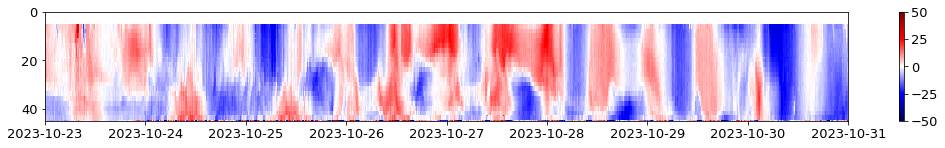

In [19]:
### SD merged nc file info
### load adcp data
ds_cur_SD = nc.Dataset(path_cur_SD+'adcp-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_cur_SD.variables['time'][:]
dtime_cur_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
uCur_SD = ds_cur_SD.variables['vel_east'][:]*100 # cm/s
vCur_SD = ds_cur_SD.variables['vel_north'][:]*100
depths_cur_SD = ds_cur_SD.variables['depth'][:] # the shallowest depth should be ~6m. 
depths_cur_SD = depths_cur_SD+1.8
print('Depths of SD:',depths_cur_SD)
### plot
plt.clf()
plt.gcf().set_size_inches(18, 2)
plt.rcParams.update({'font.size': 13})
plt.pcolor(dtime_cur_SD, depths_cur_SD, uCur_SD.transpose(),cmap='seismic',vmin=-50,vmax=50)
plt.ylim([0,45])
plt.gca().invert_yaxis()
plt.xlim(tlim_plot)
plt.colorbar()

In [20]:
### put wind to buoy currents' temporal grid
dsec_buoy = (dtime_cur_buoy[1]-dtime_cur_buoy[0]).total_seconds() # buoy current's time interval in seconds
nt_grid = int( (tlim_plot[1]-tlim_plot[0]).total_seconds()/dsec_buoy )
dtime_buoy_grid = np.array([tlim_plot[0]+datetime.timedelta(seconds=i*dsec_buoy) for i in range(nt_grid)])
print('buoy current temporal grid:',dtime_buoy_grid[0:2],dtime_buoy_grid[-1])
timestamp_buoy_grid = np.array([dtime_buoy_grid[i].timestamp() for i in range(nt_grid)])
timestamp_met_buoy = np.array([dtime_met_buoy[i].timestamp() for i in range(len(dtime_met_buoy))])
timestamp_cur_buoy = np.array([dtime_cur_buoy[i].timestamp() for i in range(len(dtime_cur_buoy))])
### 
timestamp_met_SD = np.array([dtime_met_SD[i].timestamp() for i in range(len(dtime_met_SD))])
timestamp_cur_SD = np.array([dtime_cur_SD[i].timestamp() for i in range(len(dtime_cur_SD))])
### linear interpolate wind & current's temporal grid (with limits)
isOK = ~np.isnan(uwnd_buoy)
uwnd_buoy_grid = np.interp( timestamp_buoy_grid, timestamp_met_buoy[isOK], uwnd_buoy[isOK])
vwnd_buoy_grid = np.interp( timestamp_buoy_grid, timestamp_met_buoy[isOK], vwnd_buoy[isOK])
isOK = ~np.isnan(uwnd_SD)
uwnd_SD_grid = np.interp( timestamp_buoy_grid, timestamp_met_SD[isOK], uwnd_SD[isOK])
vwnd_SD_grid = np.interp( timestamp_buoy_grid, timestamp_met_SD[isOK], vwnd_SD[isOK])

### put current to tlim_plot and put out of bound data to NaN
ucur_buoy_grid = np.nan*np.ones( (len(dtime_buoy_grid),len(depths_cur_buoy)) )
vcur_buoy_grid = ucur_buoy_grid.copy()
for z in range( len(depths_cur_buoy) ):
    isOK = ~np.isnan(uCur_buoy[:,z])
    ucur_buoy_grid[:,z] = np.interp( timestamp_buoy_grid,timestamp_cur_buoy[isOK],uCur_buoy[isOK,z],left=np.nan,right=np.nan)
    vcur_buoy_grid[:,z] = np.interp( timestamp_buoy_grid,timestamp_cur_buoy[isOK],vCur_buoy[isOK,z],left=np.nan,right=np.nan)

ucur_SD_grid = np.nan*np.ones( (len(dtime_buoy_grid),len(depths_cur_SD)) )
vcur_SD_grid = ucur_SD_grid.copy()
for z in range( len(depths_cur_SD) ):
    isOK = ~np.isnan(uCur_SD[:,z])
    ucur_SD_grid[:,z] = np.interp( timestamp_buoy_grid,timestamp_cur_SD[isOK],uCur_SD[isOK,z],left=np.nan,right=np.nan)
    vcur_SD_grid[:,z] = np.interp( timestamp_buoy_grid,timestamp_cur_SD[isOK],vCur_SD[isOK,z],left=np.nan,right=np.nan)

### compute the wind stress
iz_buoy = np.argmin( np.abs(depths_cur_buoy-6) ) ### depth indice to plot
iz_SD = np.argmin( np.abs(depths_cur_SD-6) )
roh = 1.2
taux_SD_grid, tauy_SD_grid = ra_windstr_nc(uwnd_SD_grid,vwnd_SD_grid,roh)
taux_buoy_grid, tauy_buoy_grid = ra_windstr_nc(uwnd_buoy_grid,vwnd_buoy_grid,roh)
### corrected wind stress by current velocity
taux_c_buoy_grid, tauy_c_buoy_grid = ra_windstr_nc(uwnd_buoy_grid-0.01*ucur_buoy_grid[:,iz_buoy], vwnd_buoy_grid-0.01*vcur_buoy_grid[:,iz_buoy],roh)
taux_c_SD_grid, tauy_c_SD_grid = ra_windstr_nc(uwnd_SD_grid-0.01*ucur_SD_grid[:,iz_SD], vwnd_SD_grid-0.01*vcur_SD_grid[:,iz_SD],roh)

buoy current temporal grid: [datetime.datetime(2023, 10, 23, 0, 0)
 datetime.datetime(2023, 10, 23, 1, 0)] 2023-10-30 23:00:00


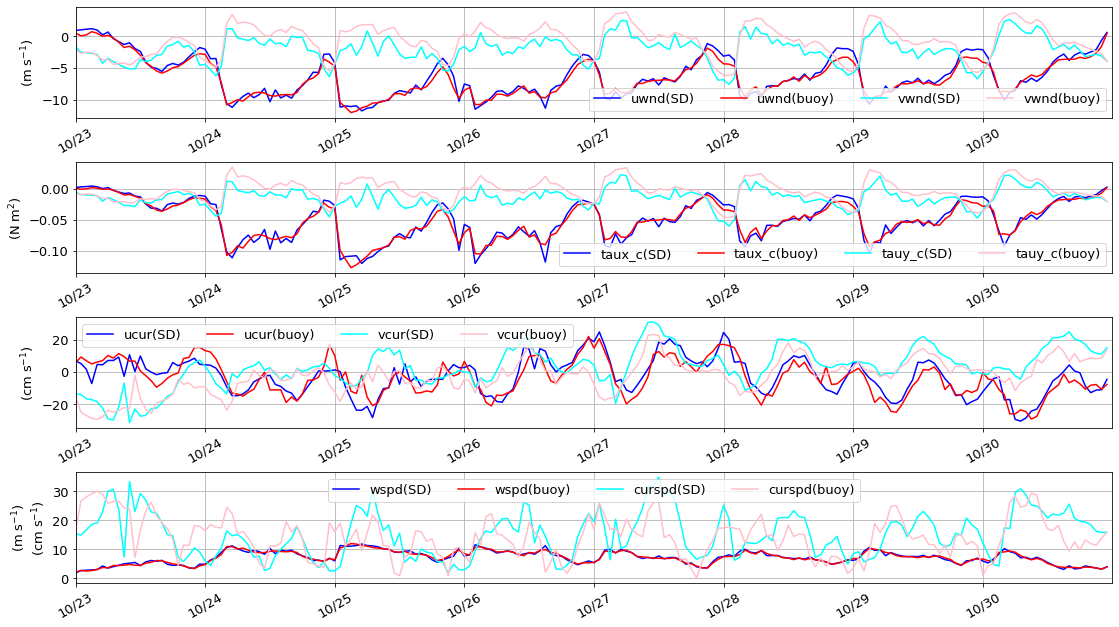

In [21]:
### plot the linearly interpolated wind and current (on current's grids)
wspd_buoy_grid = np.sqrt( np.square(uwnd_buoy_grid) + np.square(vwnd_buoy_grid) )
curspd_buoy_grid = np.sqrt( np.square(ucur_buoy_grid) + np.square(vcur_buoy_grid) )
wspd_SD_grid = np.sqrt( np.square(uwnd_SD_grid) + np.square(vwnd_SD_grid) )
curspd_SD_grid = np.sqrt( np.square(ucur_SD_grid) + np.square(vcur_SD_grid) )
###
platforms = ['SD','buoy']
var_str = [['uwnd','vwnd'],['taux_c','tauy_c'],['ucur','vcur'],['wspd','curspd']]
var_unit = ['(m s$^{-1}$)','(N m$^2$)','(cm s$^{-1}$)',['(m s$^{-1}$)','(cm s$^{-1}$)']]
col_in1 = [['blue','red'],['cyan','pink']]
### 
nrow = len(var_str)
plt.clf()
plt.gcf().set_size_inches(18, 10)
plt.rcParams.update({'font.size': 13})
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    for v in range( len(var_str[i]) ):
        exec_str1 = 'var1 = '+var_str[i][v]+'_'+platforms[0]+'_grid'
        exec_str2 = 'var2 = '+var_str[i][v]+'_'+platforms[1]+'_grid'
        if ('cur' in var_str[i][v]):# & ('spd' not in var_str[i][v]):
            exec_str1 = exec_str1+'[:,iz_'+platforms[0]+']'
            exec_str2 = exec_str2+'[:,iz_'+platforms[1]+']'
        exec(exec_str1)
        exec(exec_str2)
        plt.plot(dtime_buoy_grid, var1,color=col_in1[v][0],label=var_str[i][v]+'('+platforms[0]+')')
        plt.plot(dtime_buoy_grid, var2,color=col_in1[v][1],label=var_str[i][v]+'('+platforms[1]+')')
    plt.legend(ncol=4,loc='best')
    if isinstance(var_unit[i],str):
        plt.ylabel(var_unit[i])
    else:
        plt.ylabel('\n'.join(var_unit[i]))
    ### figure settings
    plt.xticks(tticks,rotation=30)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot)
    plt.grid()
    
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.4)
### save to figure
plt.savefig('timeseries_wind_tau_c_cur_spd_'+platf_num+'({:.1f}m)'.format(depths_cur_SD[iz_SD])+'_vs_buoy'+buoy_id+'({:.1f}m)'.format(depths_cur_buoy[iz_buoy])+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'_on-buoy-cur-grid.png',dpi=400,bbox_inches='tight')

In [32]:
### band pass current velocity to NI band
f_buoy = 2*(2*np.pi/86400)*np.sin(lat_buoy/180*np.pi) # 1/s
n_f = np.array([0.75,1.25]) #[0.8,1.2]
f_bp = f_buoy*n_f
ucur_buoy_grid_bp = np.nan*np.ones( ucur_buoy_grid.shape )
vcur_buoy_grid_bp = ucur_buoy_grid_bp.copy()
ucur_SD_grid_bp = ucur_buoy_grid_bp.copy()
vcur_SD_grid_bp = ucur_buoy_grid_bp.copy()
### buoy
bp_sec = 2*np.pi/f_bp
for z in range( ucur_buoy_grid_bp.shape[1] ):
    if np.sum( ~np.isnan(ucur_buoy_grid[:,z]) )> 10:
        ucur_buoy_grid_bp[:,z], _,_,_,_  = bandpass(ucur_buoy_grid[:,z],dsec_buoy,bp_sec[0],bp_sec[1],2)
        vcur_buoy_grid_bp[:,z], _,_,_,_  = bandpass(vcur_buoy_grid[:,z],dsec_buoy,bp_sec[0],bp_sec[1],2)
### SD
for z in range( ucur_SD_grid_bp.shape[1] ):
    if np.sum( ~np.isnan(ucur_SD_grid[:,z]) )> 10:
        ucur_SD_grid_bp[:,z], _,_,_,_  = bandpass(ucur_SD_grid[:,z],dsec_buoy,bp_sec[0],bp_sec[1],2)
        vcur_SD_grid_bp[:,z], _,_,_,_  = bandpass(vcur_SD_grid[:,z],dsec_buoy,bp_sec[0],bp_sec[1],2)

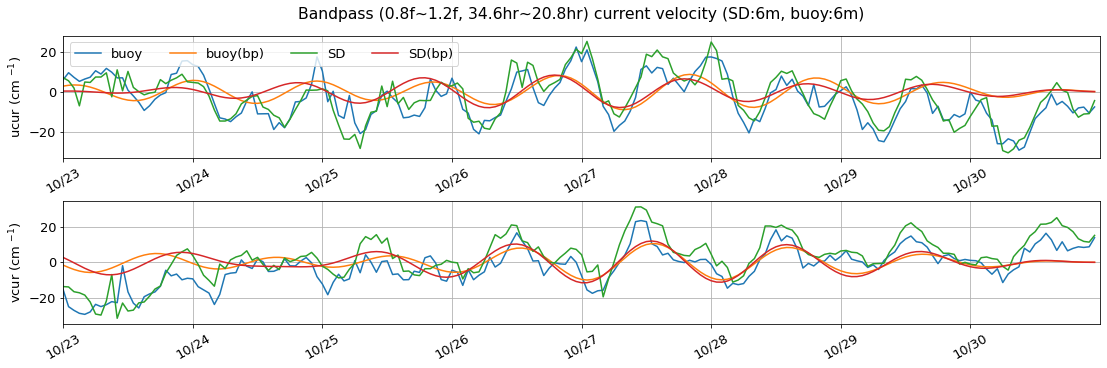

In [33]:
### plot current
nrow = 2
plt.clf()
plt.gcf().set_size_inches(18, 5)
plt.rcParams.update({'font.size': 13})
### u
plt.subplot(nrow,1,1)
plt.plot(dtime_buoy_grid, ucur_buoy_grid[:,iz_buoy],label='buoy')
plt.plot(dtime_buoy_grid, ucur_buoy_grid_bp[:,iz_buoy],label='buoy(bp)')
plt.plot(dtime_buoy_grid, ucur_SD_grid[:,iz_SD],label='SD')
plt.plot(dtime_buoy_grid, ucur_SD_grid_bp[:,iz_SD],label='SD(bp)')
plt.ylabel('ucur (cm $^{-1}$)')
plt.legend(ncol=4,loc='best')
### v
plt.subplot(nrow,1,2)
plt.plot(dtime_buoy_grid, vcur_buoy_grid[:,iz_buoy],label='buoy')
plt.plot(dtime_buoy_grid, vcur_buoy_grid_bp[:,iz_buoy],label='buoy(bp)')
plt.plot(dtime_buoy_grid, vcur_SD_grid[:,iz_SD],label='SD')
plt.plot(dtime_buoy_grid, vcur_SD_grid_bp[:,iz_SD],label='SD(bp)')
plt.ylabel('vcur (cm $^{-1}$)')
###
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xticks(tticks,rotation=30)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot)
    plt.grid()
    
plt.suptitle('Bandpass ({:.1f}f~{:.1f}f, {:.1f}hr~{:.1f}hr) current velocity (SD:{:.0f}m, buoy:{:.0f}m)'.\
             format(n_f[0],n_f[1],bp_sec[0]/3600,bp_sec[1]/3600,depths_cur_SD[iz_SD],depths_cur_buoy[iz_buoy]))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)
# ### save to figure
# plt.savefig('timeseries_cur-bp({:.1f}f~{:.1f}f)_'.format(n_f[0],n_f[1])+platf_num+'({:.1f}m)'.format(depths_cur_SD[iz_SD])+'_vs_buoy'+buoy_id+'({:.1f}m)'.format(depths_cur_buoy[iz_buoy])+'_'+\
#             tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'_from-buoy-cur-grid.png',dpi=400,bbox_inches='tight')

In [34]:
### compute wind power (N m^-2)*(m s^-1)= N m^-1 s^-1 = J m^-2 s^-1 = W m^-2
tau_dot_sfcvel_buoy = np.multiply(taux_c_buoy_grid,(0.01*ucur_buoy_grid_bp[:,iz_buoy])) +\
    np.multiply(tauy_c_buoy_grid,(0.01*vcur_buoy_grid_bp[:,iz_buoy]))
tau_dot_sfcvel_SD = np.multiply(taux_c_SD_grid,(0.01*ucur_SD_grid_bp[:,iz_SD])) +\
    np.multiply(tauy_c_SD_grid,(0.01*vcur_SD_grid_bp[:,iz_SD]))
### compute energy input (W m^-2)*(s) = J m^-2
energy_input_buoy = np.nan*np.ones( (len(dtime_buoy_grid),) )
energy_input_SD = energy_input_buoy.copy()
for i in range( len(dtime_buoy_grid) ):
    energy_input_buoy[i] = np.trapz(tau_dot_sfcvel_buoy[:i+1],timestamp_buoy_grid[:i+1])
    energy_input_SD[i] = np.trapz(tau_dot_sfcvel_SD[:i+1],timestamp_buoy_grid[:i+1])   

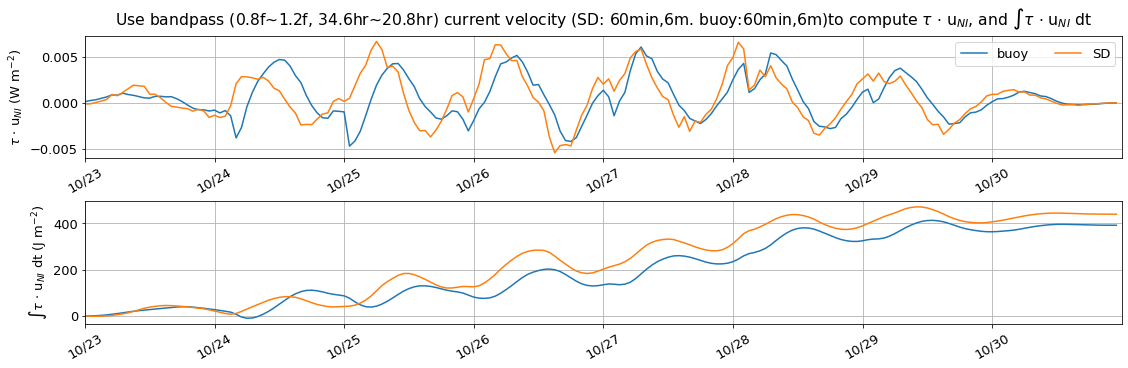

In [35]:
### plot wind power (tau dot NI current velocity in W m^-2) and energy input (integrate wind power over time in J m^-2)
nrow = 2
plt.clf()
plt.gcf().set_size_inches(18, 5)
plt.rcParams.update({'font.size': 13})
### wind power
plt.subplot(nrow,1,1)
plt.plot( dtime_buoy_grid, tau_dot_sfcvel_buoy, label='buoy')
plt.plot( dtime_buoy_grid, tau_dot_sfcvel_SD, label='SD')
plt.legend(ncol=nrow, loc='best')
plt.ylabel('$\u03C4$ $\cdot$ u$_{NI}$ (W m$^{-2}$)')
### energy input
plt.subplot(nrow,1,2)
plt.plot( dtime_buoy_grid, energy_input_buoy, label='buoy')
plt.plot( dtime_buoy_grid, energy_input_SD, label='SD')
plt.ylabel('$\int$$\u03C4$ $\cdot$ u$_{NI}$ dt (J m$^{-2}$)')
### figure setting
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xticks(tticks,rotation=30)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot)
    plt.grid()

plt.suptitle('Use bandpass ({:.1f}f~{:.1f}f, {:.1f}hr~{:.1f}hr) current velocity (SD: {:.0f}min,{:.0f}m. buoy:{:.0f}min,{:.0f}m)'.\
             format(n_f[0],n_f[1],bp_sec[0]/3600,bp_sec[1]/3600,dsec_buoy/60,depths_cur_SD[iz_SD],dsec_buoy/60,depths_cur_buoy[iz_buoy])+\
                'to compute $\u03C4$ $\cdot$ u$_{NI}$, and $\int$$\u03C4$ $\cdot$ u$_{NI}$ dt')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)
### save figure
# plt.savefig('timeseries_wind-power_energy-input_bp({:.1f}f~{:.1f}f)_'.format(n_f[0],n_f[1])+\
#             platf_num+'({:.1f}m)'.format(depths_cur_SD[iz_SD])+'_vs_buoy'+buoy_id+'({:.1f}m)'.format(depths_cur_buoy[iz_buoy])+'_'+\
#             tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'_from-buoy-cur-grid.png',dpi=400,bbox_inches='tight')

In [36]:
tlim_check = [datetime.datetime(int(year),10,30),datetime.datetime(int(year),10,31)]
it = np.where( (dtime_buoy_grid>= tlim_check[0]) & (dtime_buoy_grid<= tlim_check[1]) )[0]
res = []
for i in range( len(platforms) ):
    mn = np.mean( eval('energy_input_'+platforms[i]+'[it]') )
    res.append(mn)
    print(platforms[i],' mean energy input btw',tlim_check,'= {:.2f} (J/m^2)'.format(mn))
print(platforms[0]+'/'+platforms[1],res[0]/res[1])

SD  mean energy input btw [datetime.datetime(2023, 10, 30, 0, 0), datetime.datetime(2023, 10, 31, 0, 0)] = 434.89 (J/m^2)
buoy  mean energy input btw [datetime.datetime(2023, 10, 30, 0, 0), datetime.datetime(2023, 10, 31, 0, 0)] = 386.01 (J/m^2)
SD/buoy 1.1266288937062885


In [13]:
### write data to text/ csv file
header = 'datetime, uwnd(m/s), vwnd(m/s), taux_c(N/m^2), tauy_c(N/m^2), ucur({:.0f}m)(cm/s), vcur({:.0f}m)(cm/s), tau dot cur(W/m^2), energy input(J/m^2)'\
    .format(depths_cur_SD[iz_SD],depths_cur_SD[iz_SD])+'. Note: NI band is {:.1f}~{:.1f}f at {:.3f}N'.format(n_f[0],n_f[1],lat_buoy)
for p in range( len(platforms) ):
    if p == 0: ### output SD's result only. buoy's result is the same as from compute_wind_power_input.ipynb
        arr_out = np.column_stack( (dtime_buoy_grid, uwnd_SD_grid, vwnd_SD_grid, taux_c_SD_grid, tauy_c_SD_grid, \
                                    ucur_SD_grid[:,iz_SD], vcur_SD_grid[:,iz_SD], tau_dot_sfcvel_SD, energy_input_SD) )
    # elif p == 1:
    #     arr_out = np.column_stack( (dtime_buoy_grid, uwnd_buoy_grid, vwnd_buoy_grid, taux_c_buoy_grid, tauy_c_buoy_grid, \
    #                                 ucur_buoy_grid[:,iz_buoy], vcur_buoy_grid[:,iz_buoy], tau_dot_sfcvel_buoy, energy_input_buoy) )
        ### write to a file
        fileID = open('timeseries_'+platforms[p]+'_wind-power-input_on-buoy-cur-grid_'+tlim_plot[0].strftime('%Y%m%d%HZ-')+tlim_plot[1].strftime('%m%d%HZ')+'.txt','w')
        np.savetxt(fileID,arr_out,fmt='%s',header=header)
        fileID.close()

In [ ]:
### plot and compare the results from 5-min & hourly grid of wind power energy input estimation from SD-1042
fn_SD_5min_grid = 'timeseries_SD_wind-power-input_on-cur-grid_'+tlim_plot[0].strftime('%Y%m%d%HZ-')+tlim_plot[1].strftime('%m%d%HZ')+'.txt'
dataIN_SD_5min_grid = np.genfromtxt(fn_SD_5min_grid, skip_header=1, dtype=str)
dtimeIN_SD = np.array([datetime.datetime.strptime(dataIN_SD_5min_grid[i,0]+' '+dataIN_SD_5min_grid[i,1],'%Y-%m-%d %H:%M:%S') for i in range(dataIN_SD_5min_grid.shape[0])])

### plot wind power (tau dot NI current velocity in W m^-2) and energy input (integrate wind power over time in J m^-2)
nrow = 2
plt.clf()
plt.gcf().set_size_inches(18, 5)
plt.rcParams.update({'font.size': 13})
### wind power
plt.subplot(nrow,1,1)
plt.plot( dtime_buoy_grid, tau_dot_sfcvel_buoy, label='buoy')
plt.plot( dtime_buoy_grid, tau_dot_sfcvel_SD, label='SD')
y = np.array([float(dataIN_SD_5min_grid[i,-2]) for i in range(len(dtimeIN_SD))])
plt.plot( dtimeIN_SD, y, label='SD (5min-grid)')
plt.legend(ncol=3, loc='best')
plt.ylabel('$\u03C4$ $\cdot$ u$_{NI}$ (W m$^{-2}$)')
### wind power
plt.subplot(nrow,1,2)
plt.plot( dtime_buoy_grid, energy_input_buoy, label='buoy')
plt.plot( dtime_buoy_grid, energy_input_SD, label='SD')
y = np.array([float(dataIN_SD_5min_grid[i,-1]) for i in range(len(dtimeIN_SD))])
plt.plot( dtimeIN_SD, y, label='SD (hr-grid)')
plt.ylabel('$\int$$\u03C4$ $\cdot$ u$_{NI}$ dt (J m$^{-2}$)')
### figure setting
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xticks(tticks,rotation=30)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot)
    plt.grid()

plt.suptitle('Use bandpass ({:.1f}f~{:.1f}f, {:.1f}hr~{:.1f}hr) current velocity (SD: {:.0f}min,{:.0f}m. buoy:{:.0f}min,{:.0f}m)'.\
             format(n_f[0],n_f[1],bp_sec[0]/3600,bp_sec[1]/3600,dsec_buoy/60,depths_cur_SD[iz_SD],dsec_buoy/60,depths_cur_buoy[iz_buoy])+\
                'to compute $\u03C4$ $\cdot$ u$_{NI}$, and $\int$$\u03C4$ $\cdot$ u$_{NI}$ dt')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)
### save figure
plt.savefig('timeseries_wind-power_energy-input_bp({:.1f}f~{:.1f}f)_'.format(n_f[0],n_f[1])+\
            platf_num+'({:.1f}m)'.format(depths_cur_SD[iz_SD])+'_vs_buoy'+buoy_id+'({:.1f}m)'.format(depths_cur_buoy[iz_buoy])+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'_2-SD-grids.png',dpi=400,bbox_inches='tight')

OSError: timeseries_SD_wind-power-input_on-cur-grid_2023102300Z-103100Z.txt not found.